In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar
import os

from matplotlib.legend_handler import HandlerErrorbar


In [2]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [3]:
data_loaded = pd.read_hdf('summary.h5')
data_loaded.shape


(62, 256939)

In [4]:
indx = np.isfinite(data_loaded["best18k Parallax fiveSigmaDepth, band, seeingFwhmGeom, ra_pi_amp, dec_pi_amp HealpixSlicer"].values)
data_loaded.loc[indx, ["best18k Parallax fiveSigmaDepth, filter, seeingFwhmGeom, ra_pi_amp, dec_pi_amp HealpixSlicer"]] = data_loaded["best18k Parallax fiveSigmaDepth, band, seeingFwhmGeom, ra_pi_amp, dec_pi_amp HealpixSlicer"].iloc[indx]

#for bandname in 'ugrizy':
#    indx = np.isfinite(data_loaded["Median CoaddM5 band%s HealpixSlicer" % bandname].values)
#    d1 = data_loaded["Median CoaddM5 %s HealpixSlicer" % bandname].values
#    d1[indx] = data_loaded["Median CoaddM5 band%s HealpixSlicer" % bandname].iloc[indx].values
#    data_loaded["Median CoaddM5 %s HealpixSlicer" % bandname] = d1

In [5]:
# Pull out the metrics we are interested in and define simple names

name_dict = {'FootprintFraction N year 1 u and night < 365 HealpixSlicer': 'Y1,u',
            'FootprintFraction N year 1 g and night < 365 HealpixSlicer': 'Y1,g',
            'FootprintFraction N year 1 r and night < 365 HealpixSlicer': 'Y1,r',

            'FootprintFraction N year 1 i and night < 365 HealpixSlicer': 'Y1,i',
    'best18k Parallax fiveSigmaDepth, filter, seeingFwhmGeom, ra_pi_amp, dec_pi_amp HealpixSlicer': 'parallax best 18k',
            'best18k properMotion HealpixSlicer': 'proper motion best 18k',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
             'fOArea_750 fO All sky HealpixSlicer': 'fO Area 750',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            #'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
            #'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe single model',
            #'Sum PrestoKNe_score_p UserPointsSlicer': 'KNe Score, P',
            'Sum ColorSlope visitExposureTime > 19 HealpixSlicer': 'color slope',
            "Sum ColorSlope2Night visitExposureTime > 19 HealpixSlicer": "2day\ncolor slope",
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances MBA 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'MBA',
            'CumulativeCompleteness H <= 18.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'Trojan',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira',
             'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 3 pairs in 15 nights SNR=5 detection loss MoObjSlicer': 'Vatira 3pairs, 15days, snr=5',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances PHA 1 quad in 1 night detection loss MoObjSlicer': 'PHA, quad',
            'Fraction detected of total (mean) KNePopMetric_single_multi_color_detect single model UserPointsSlicer': "KNe\n multi-color"}
            
# drop in the units for the columns
units = {'parallax best 18k': 'mas',
         'proper motion best 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'fO Area 750': '',
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe ZTF simple': 'N', 
         'KNe single model': 'N',
         'KNe Score, P': 'score',
         'XRB\nearly detect': 'N', 
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'MBA':'fraction',
         'Trojan': 'fraction',
         'Vatira': 'fraction',
         'Vatira 3pairs, 15days, snr=5': "fraction",
         'PHA, quad': 'fraction',
         'Y1,u': '',
         'Y1,g': '',
         'Y1,r': '',
         'Y1,i': '',
         'color slope': 'N',
         '2day\ncolor slope': 'N',
         "KNe\n multi-color": "fraction",
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax best 18k', 'proper motion best 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira', 'MBA', 'Trojan',
           'u', 'g', 'r', 'i', 'z', 'y']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
            
           'Total detected KNePopMetric_DD:COSMOS_ztfrest_simple DD:COSMOS UserPointsSlicer': 'Kne COSMOS',
         'Total detected KNePopMetric_DD:ECDFS_ztfrest_simple DD:ECDFS UserPointsSlicer': 'Kne ECDFS',
 'Total detected KNePopMetric_DD:EDFS_ztfrest_simple DD:EDFS UserPointsSlicer': 'Kne EDFS',
 'Total detected KNePopMetric_DD:ELAISS1_ztfrest_simple DD:ELAISS1 UserPointsSlicer': 'Kne ELAISS1',
 'Total detected KNePopMetric_DD:WFD_ztfrest_simple DD:WFD UserPointsSlicer': 'Kne WFD',
 'Total detected KNePopMetric_DD:XMM_LSS_ztfrest_simple DD:XMM_LSS UserPointsSlicer': 'Kne XMM_LSS',
            
            'Median DD:COSMOS NVisits all bands HealpixSubsetSlicer':'N COSMOS',
 'Median DD:ECDFS NVisits all bands HealpixSubsetSlicer': 'N ECDFS',
 'Median DD:EDFS NVisits all bands HealpixSubsetSlicer': 'N EDFS',
 'Median DD:ELAISS1 NVisits all bands HealpixSubsetSlicer': 'N ELAISS1',
 'Median DD:WFD NVisits all bands HealpixSubsetSlicer': 'N WFD',
 'Median DD:XMM_LSS NVisits all bands HealpixSubsetSlicer': 'N XMM_LSS', 
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 
gaps_dict = {}
for filtername in 'ugrizy':
    for times in [3,7,24]:
        gaps_dict['Mean N gaps in %s at %ihr in top 18k Gaps_%ihr %s band HealpixSlicer'% (filtername, times, times, filtername)] = 'gaps %s %i' % (filtername, times)
        #gaps_dict['Mean Gaps_%ihr %s band HealpixSlicer' % (times, filtername)] = 'gaps %s %i' % (filtername, times)
        
gaps_data = pd.DataFrame()
for key in gaps_dict:
    gaps_data[gaps_dict[key]] = data_loaded[key]

In [6]:
[name for name in mag_data.index if "prod" in name]

['baseline_production_v5.0.1_10yrs', 'production_templates_y1_v5.0.1_10yrs']

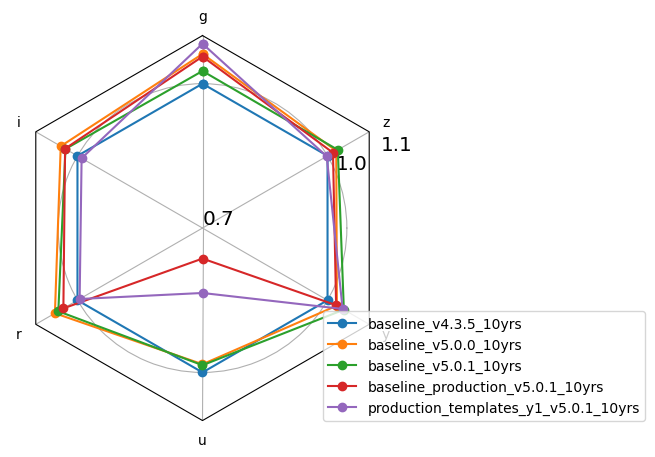

In [7]:
runs = ['baseline_v4.3.5_10yrs', 'baseline_v5.0.0_10yrs', 'baseline_v5.0.1_10yrs', 'baseline_production_v5.0.1_10yrs', 'production_templates_y1_v5.0.1_10yrs']
ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                 mag_cols = mag_cols, norm_run='baseline_v4.3.5_10yrs')#, invert_cols=['u', 'g', 'r', 'i', 'z', 'y'])
fig, ax = radar(ndata, legend=True, rgrids=[0.7, 1.0, 1.1], bbox_to_anchor=(1.65, 0))


In [8]:
mag_data.loc[runs]

,g,i,r,u,y,z
run_name,,,,,,
baseline_v4.3.5_10yrs,26.745644,26.351419,26.840890,25.545887,24.732823,25.701652
baseline_v5.0.0_10yrs,26.807468,26.391569,26.894996,25.528865,24.755258,25.722585
baseline_v5.0.1_10yrs,26.771999,26.380218,26.886796,25.530906,24.771967,25.726439
baseline_production_v5.0.1_10yrs,26.802019,26.381176,26.874695,25.309278,24.753399,25.714734
production_templates_y1_v5.0.1_10yrs,26.828681,26.341499,26.835662,25.380798,24.769001,25.699735


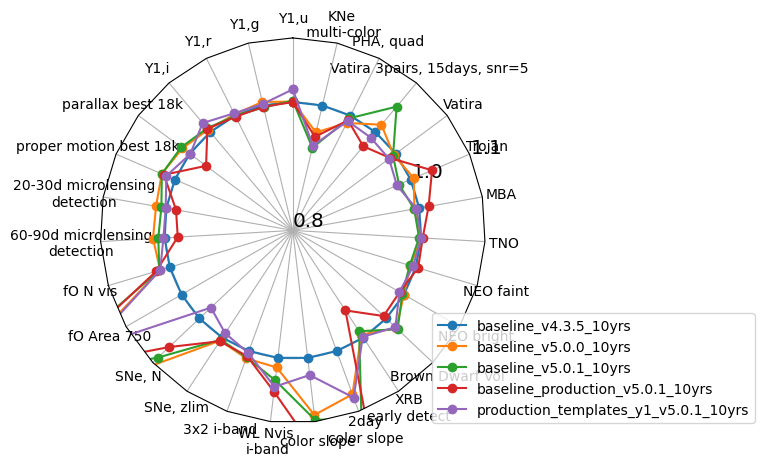

In [9]:
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v4.3.5_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.1], bbox_to_anchor=(1.7, 0))


In [10]:
ndata

,"Y1,u","Y1,g","Y1,r","Y1,i",parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,fO Area 750,...,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira,"Vatira 3pairs, 15days, snr=5","PHA, quad",KNe\n multi-color
run_name,,,,,,,,,,,,,,,,,,,,,
baseline_v4.3.5_10yrs,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.0000,1.000000,1.000000,...,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000
baseline_v5.0.0_10yrs,1.000722,1.005760,1.002360,1.005167,1.014266,1.022403,1.0164,1.0182,1.015686,1.179069,...,1.021938,1.0000,0.991413,1.000624,0.992381,1.005505,0.9962,1.014925,0.987397,0.956904
baseline_v5.0.1_10yrs,1.002311,0.996870,0.999876,1.007687,1.016863,1.022262,1.0079,1.0100,1.016993,1.270142,...,1.024567,0.9972,0.990265,0.997179,0.992090,0.980449,0.9948,1.051772,0.995395,0.932331
baseline_production_v5.0.1_10yrs,1.000000,0.997996,0.998261,1.007057,0.968429,1.018732,0.9847,0.9796,1.022222,1.234475,...,0.994511,0.9924,1.003938,1.002821,1.014922,1.036377,0.9890,0.971082,0.991876,0.949915
production_templates_y1_v5.0.1_10yrs,1.019792,1.002504,1.004099,1.018399,0.999213,1.014589,1.0011,1.0019,1.015686,1.166890,...,1.019838,0.9920,0.995675,1.000478,0.995584,0.976822,0.9870,0.988806,0.990716,0.935675


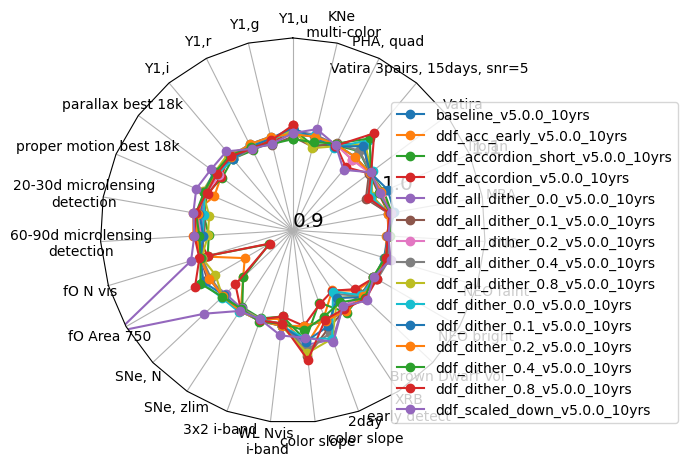

In [11]:
runs = ['baseline_v5.0.0_10yrs'] + [run for run in data_loaded.index if 'ddf' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v5.0.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.5, 0))


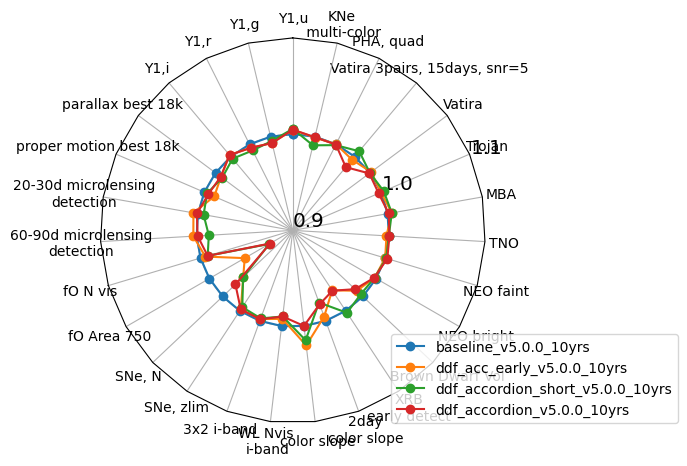

In [12]:
runs = ['baseline_v5.0.0_10yrs'] + [run for run in data_loaded.index if 'ddf_acc' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v5.0.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.5, 0))


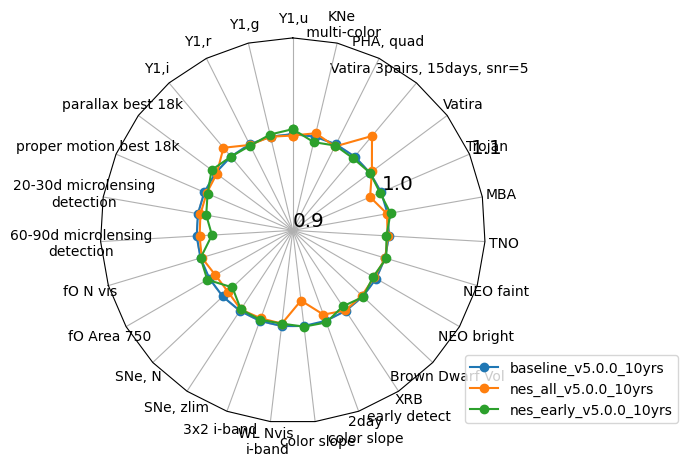

In [13]:
runs = ['baseline_v5.0.0_10yrs'] + [run for run in data_loaded.index if 'nes' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v5.0.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.5, 0))


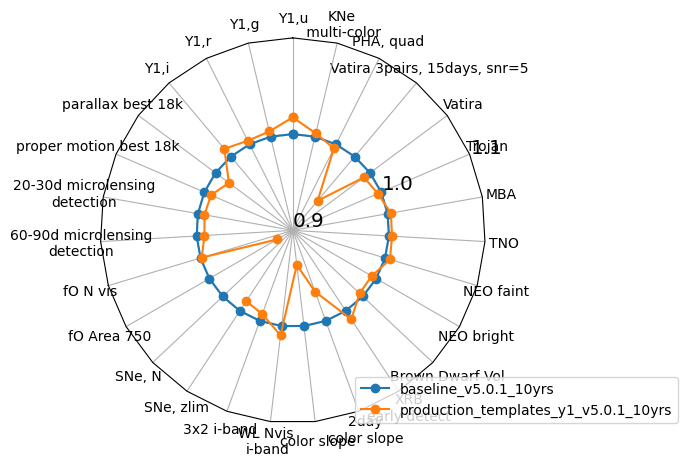

In [14]:
runs = ['baseline_v5.0.1_10yrs'] + [run for run in data_loaded.index if 'production_temp' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v5.0.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.5, 0))


In [15]:
ndata["SNe, N"]

run_name
baseline_v5.0.1_10yrs                   1.000000
production_templates_y1_v5.0.1_10yrs    0.895892
Name: SNe, N, dtype: float64

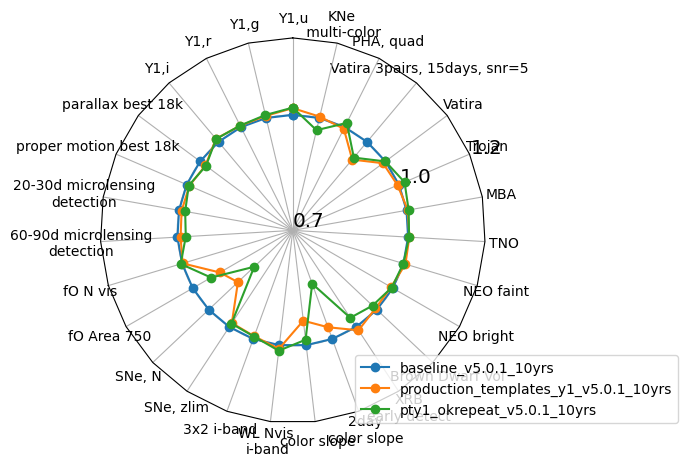

In [16]:
runs = ['baseline_v5.0.1_10yrs'] + [run for run in data_loaded.index if 'production_temp' in run]  + [run for run in data_loaded.index if 'pty1' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v5.0.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.7, 1.0, 1.2], bbox_to_anchor=(1.5, 0))


In [17]:
ndata["SNe, N"]

run_name
baseline_v5.0.1_10yrs                   1.000000
production_templates_y1_v5.0.1_10yrs    0.895892
pty1_okrepeat_v5.0.1_10yrs              0.837630
Name: SNe, N, dtype: float64

In [18]:
data.index.values[~np.isfinite(data["SNe, N"])]

array(['ddf_all_dither_0.1_v5.0.0_10yrs',
       'ddf_all_dither_0.2_v5.0.0_10yrs', 'ddf_dither_0.8_v5.0.0_10yrs',
       'retrospec_v5.0.1_10yrs', 'weather_cloudso14v5.0.0_10yrs',
       'weather_cloudso35v5.0.0_10yrs', 'weather_cloudso8v5.0.0_10yrs'],
      dtype=object)

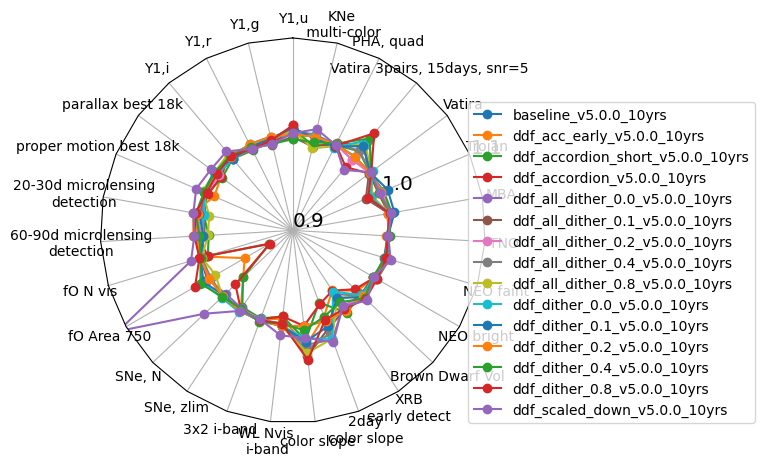

In [19]:
runs = ['baseline_v5.0.0_10yrs'] +[run for run in data.index if 'ddf' in run]

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v5.0.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.7, 0))

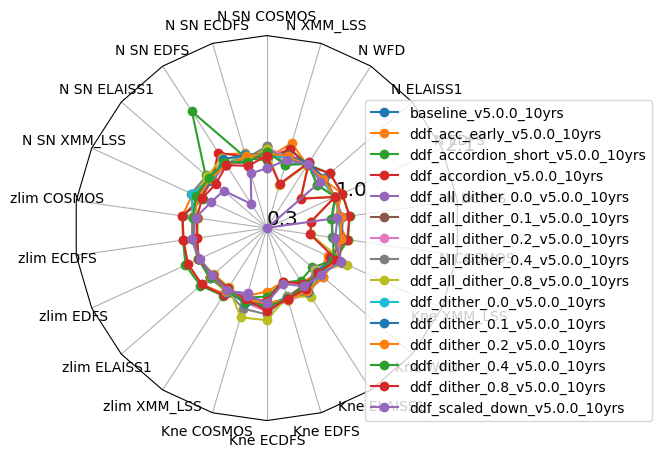

In [20]:
ndata = norm_df(ddf_data, runs, cols=ddf_data.columns.values.tolist(),
                 norm_run='baseline_v5.0.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.3, 1.0, 2.1], bbox_to_anchor=(1.5, 0))


In [21]:
times = ['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
        'baseline_v3.0_10yrs',  'baseline_v3.2_10yrs', 'baseline_v3.3_10yrs', 'baseline_v3.4_10yrs', 
          'baseline_v3.5_10yrs', 'baseline_v3.6_10yrs', 'baseline_v4.0_10yrs', 'baseline_v4.1_10yrs',
         'baseline_v4.2_10yrs', "baseline_v4.3.5_10yrs","baseline_v5.0.0_10yrs","baseline_v5.0.1_10yrs",
         "baseline_production_v5.0.1_10yrs"
        ]

sub_data = data.reindex(labels=times)
sub_ddf = ddf_data.reindex(labels=times)
sub_mag = mag_data.reindex(labels=times)
sub_gaps = gaps_data.reindex(labels=times)
sub_data

,"Y1,u","Y1,g","Y1,r","Y1,i",parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,fO Area 750,...,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira,"Vatira 3pairs, 15days, snr=5","PHA, quad",KNe\n multi-color
run_name,,,,,,,,,,,,,,,,,,,,,
retro_baseline_v2.0_10yrs,0.892997,0.948610,0.960840,0.958493,0.806655,0.177145,0.0877,0.1567,844.0,18118.671213,...,179114.337158,0.9048,0.623987,0.705883,0.943588,0.666843,0.0000,0.0000,0.847360,0.046236
baseline_v2.0_10yrs,0.954102,0.981223,0.994441,0.997035,0.793201,0.184595,0.3116,0.4343,834.0,18602.104352,...,167595.204773,0.9294,0.641643,0.719657,0.918853,0.587761,0.0039,0.0001,0.858612,0.051290
baseline_v2.1_10yrs,0.947824,0.984064,0.996665,0.999012,0.808880,0.188682,0.3138,0.4315,834.0,18655.819146,...,163335.805265,0.9286,0.647493,0.723151,0.927147,0.608476,0.0017,0.0004,0.863941,0.052746
baseline_v2.2_10yrs,0.869001,0.913280,0.993576,0.997900,0.794958,0.186814,0.3263,0.4484,826.0,18594.550710,...,171949.790286,0.9304,0.657326,0.723757,0.933532,0.615050,0.0008,0.0000,0.857143,0.056264
baseline_v3.0_10yrs,0.810826,0.900309,0.993823,0.999135,0.794761,0.186153,0.3227,0.4522,791.0,17450.593471,...,167538.768999,0.9326,0.642039,0.722257,0.923939,0.610659,0.0374,0.0002,0.886783,0.053112
baseline_v3.2_10yrs,0.973214,0.981841,0.996170,0.995800,0.785002,0.185884,0.3429,0.4865,801.0,18252.118902,...,173524.077129,0.9458,0.641833,0.720682,0.926269,0.588185,0.4627,0.2348,0.892336,0.054538
baseline_v3.3_10yrs,0.987165,0.992712,0.997529,0.996294,0.756212,0.179475,0.3815,0.5224,807.0,18522.371456,...,187648.374486,0.9440,0.659439,0.722520,0.942300,0.629354,0.4601,0.2316,0.905774,0.058824
baseline_v3.4_10yrs,0.980887,0.990241,0.995182,0.997406,0.754666,0.178122,0.3650,0.5174,812.0,18719.605463,...,188148.511393,0.9472,0.666934,0.727676,0.943417,0.633808,0.4633,0.2352,0.902250,0.059110
baseline_v3.5_10yrs,0.982561,0.995059,0.998888,0.997406,0.749014,0.176342,0.3729,0.5189,799.0,17973.473412,...,181160.990452,0.9468,0.668745,0.725868,0.938182,0.603993,0.4664,0.2391,0.910419,0.058878


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_67196/2854613832.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',


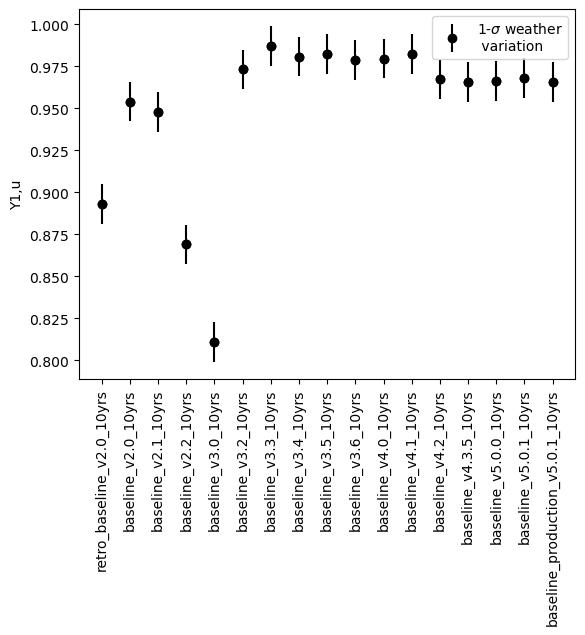

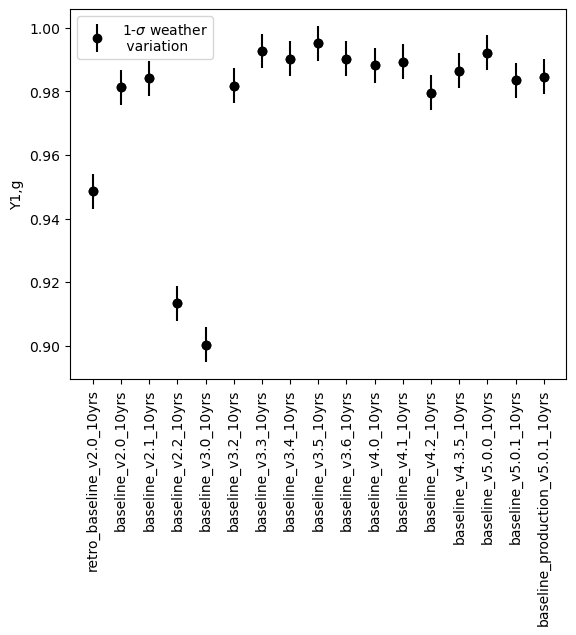

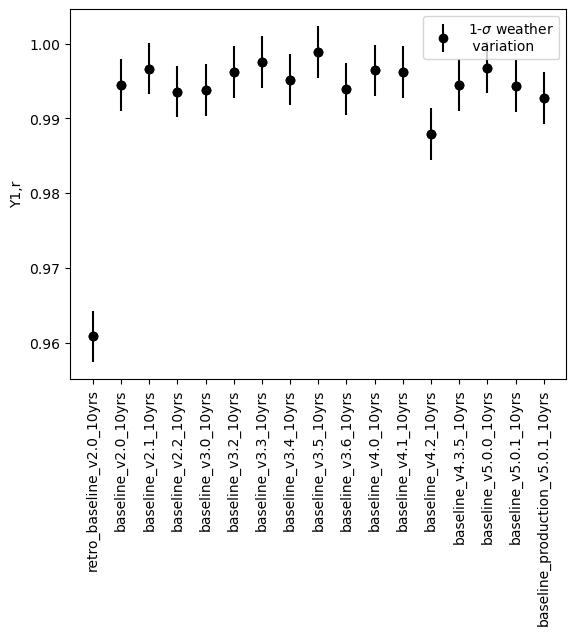

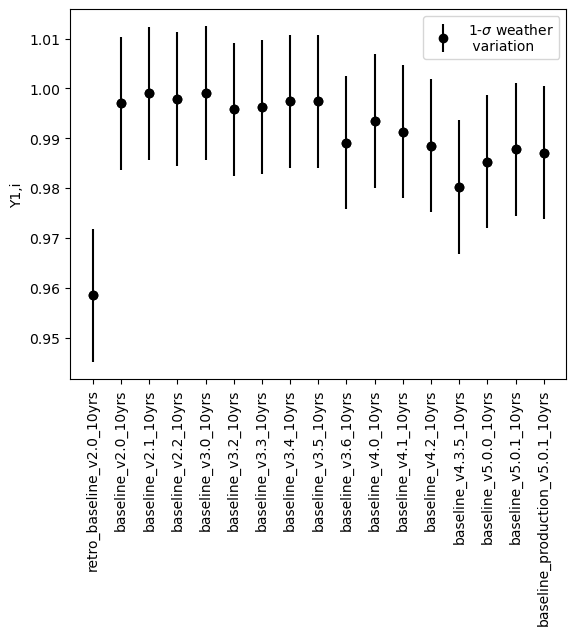

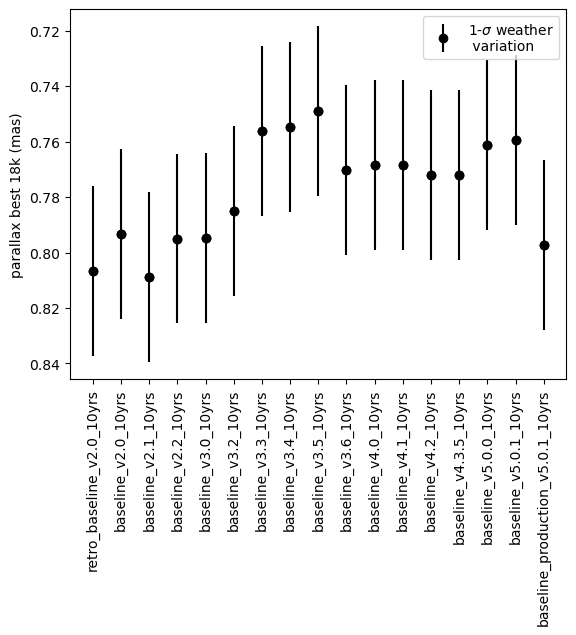

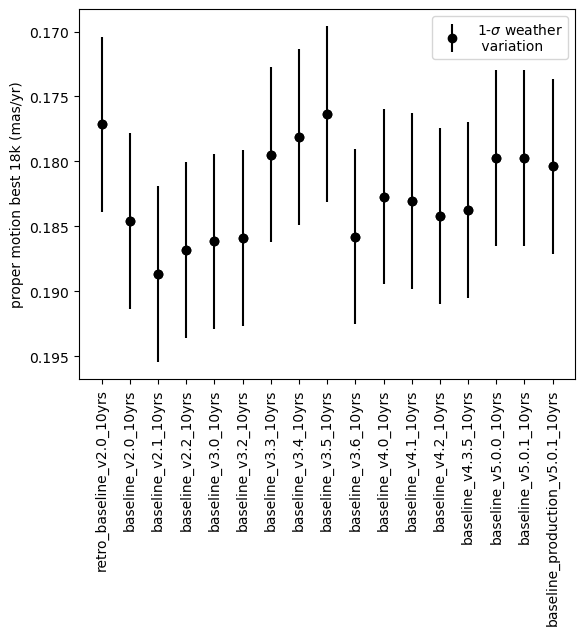

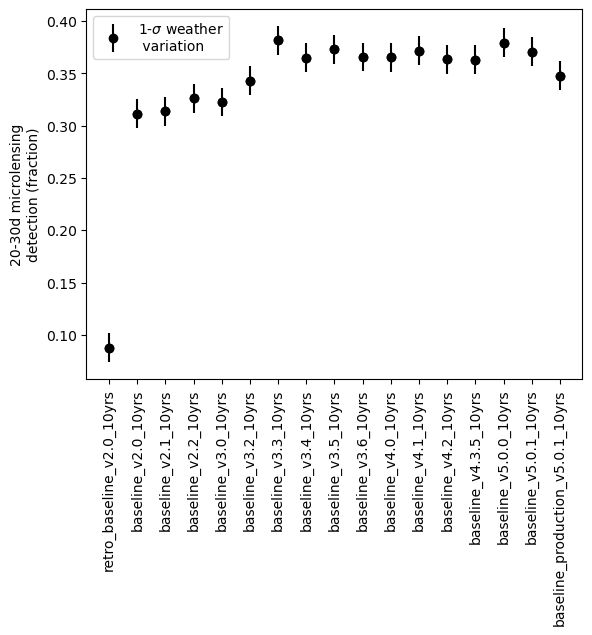

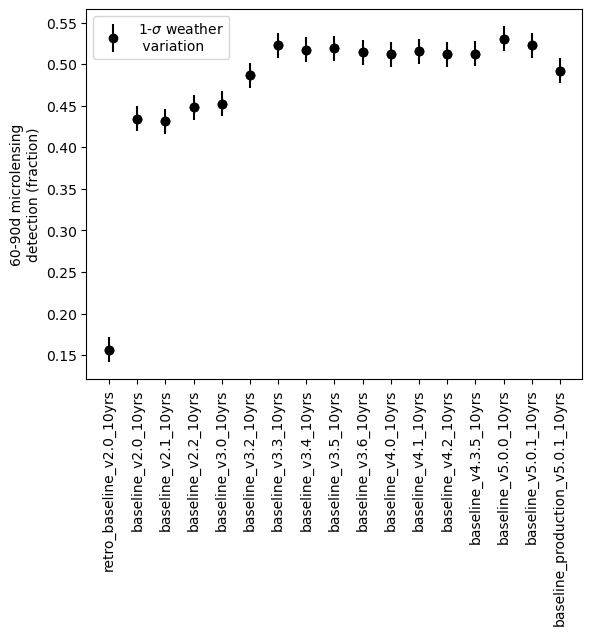

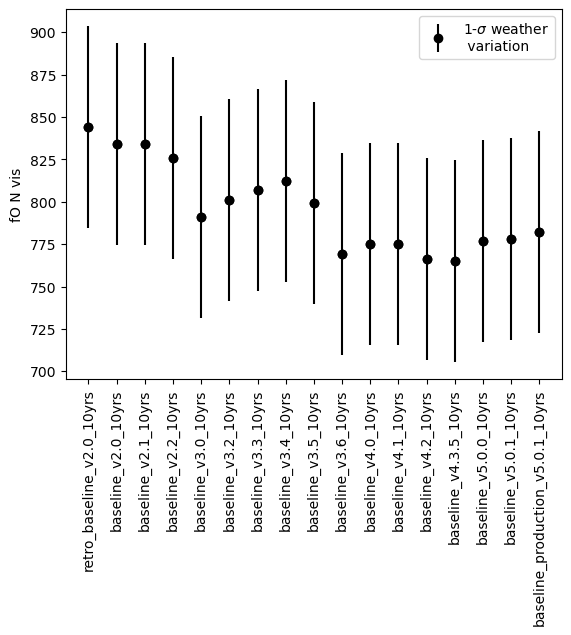

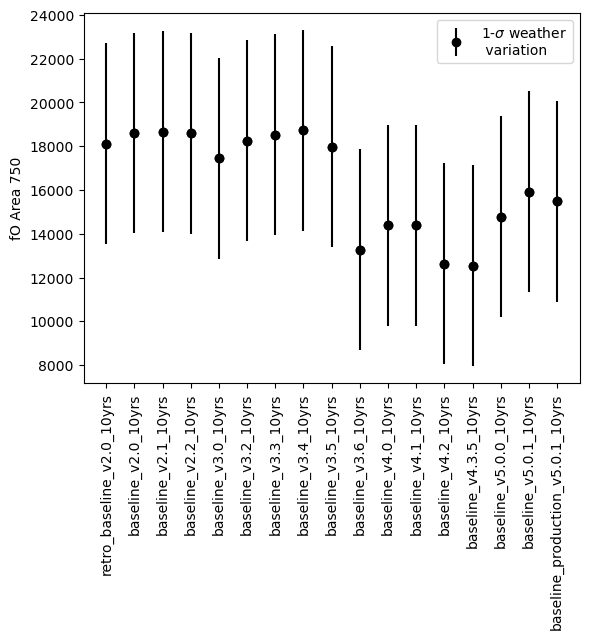

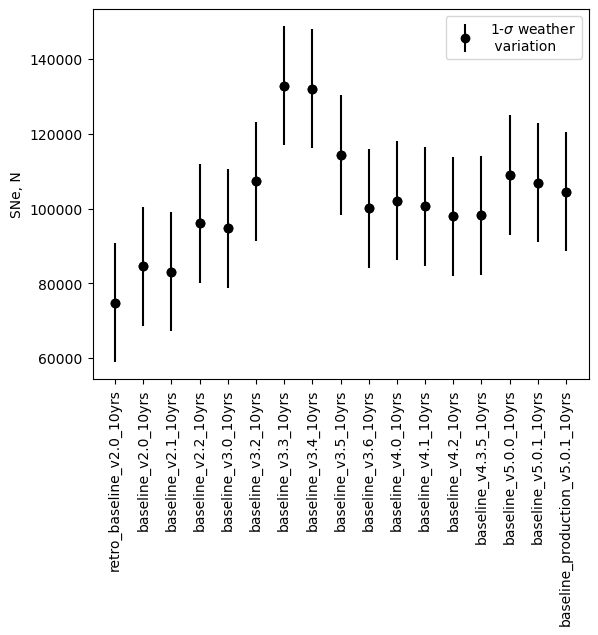

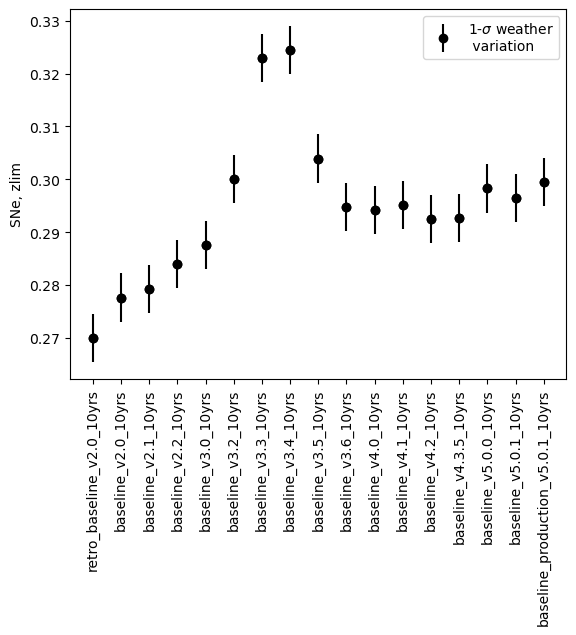

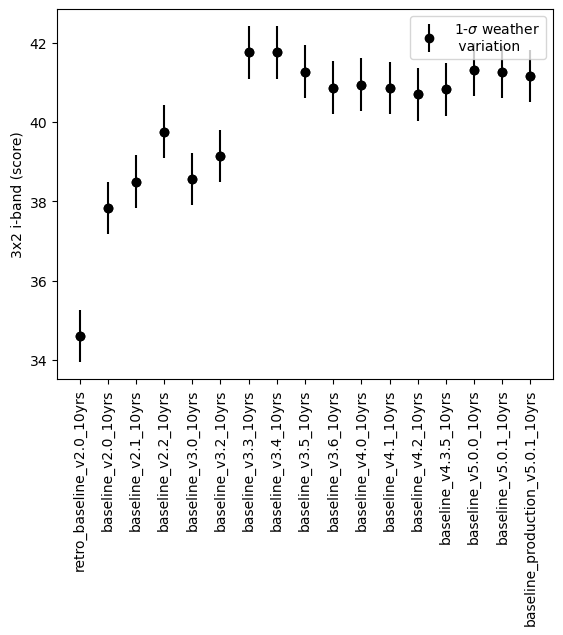

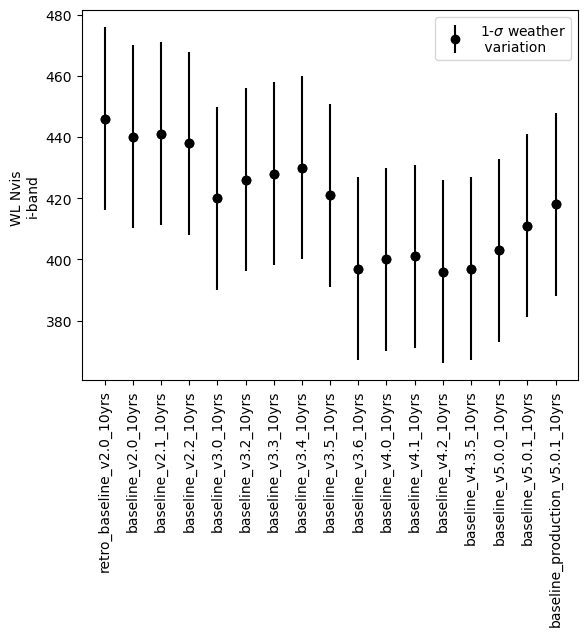

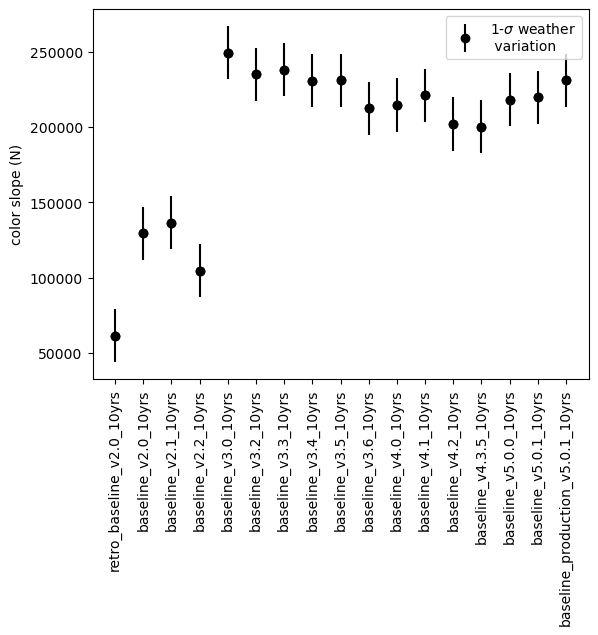

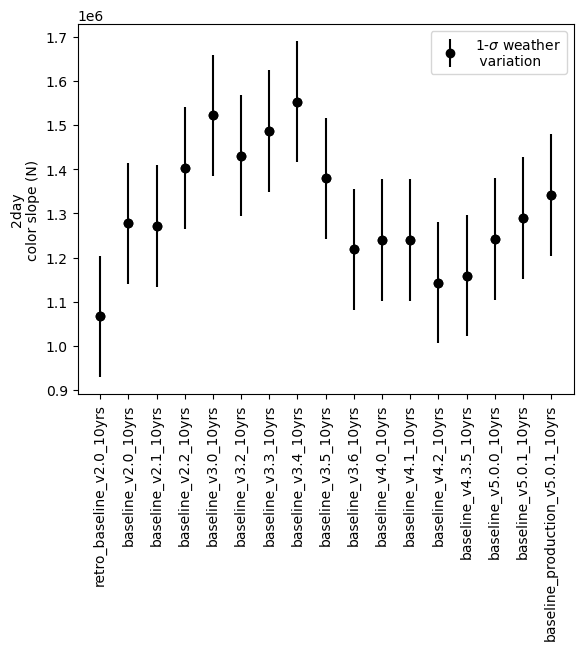

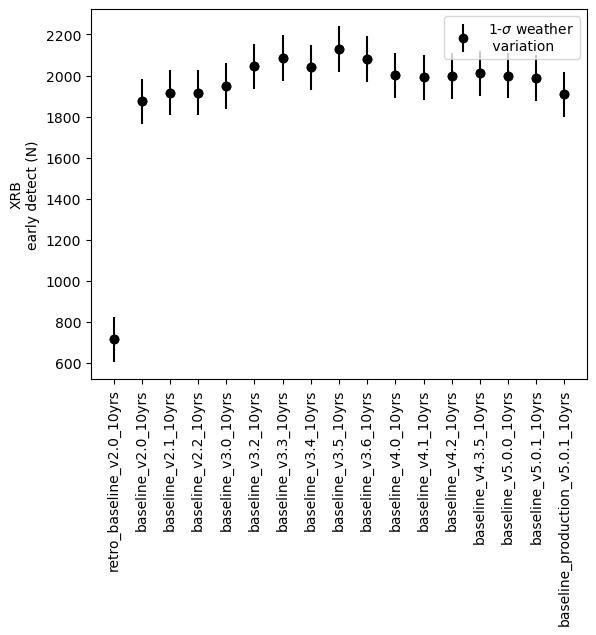

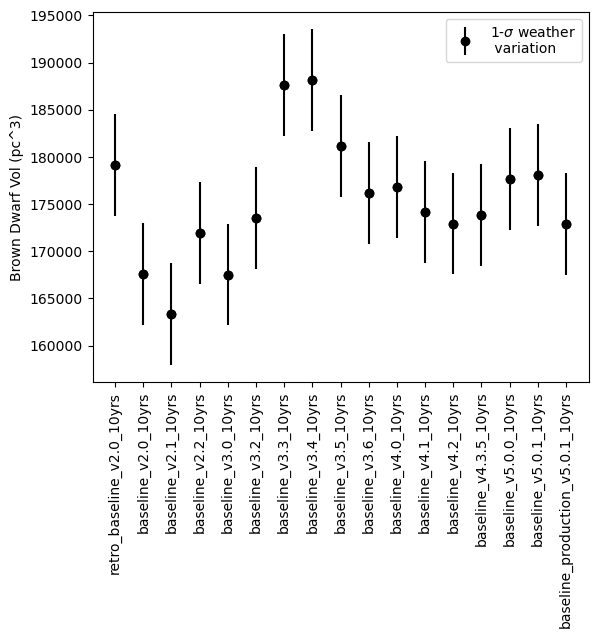

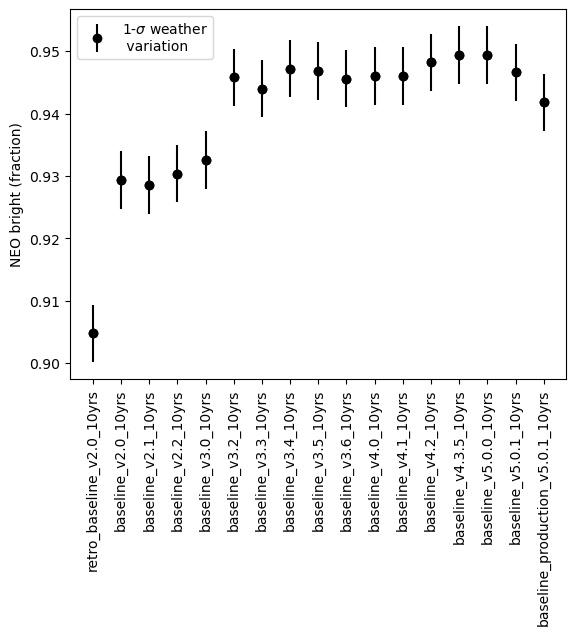

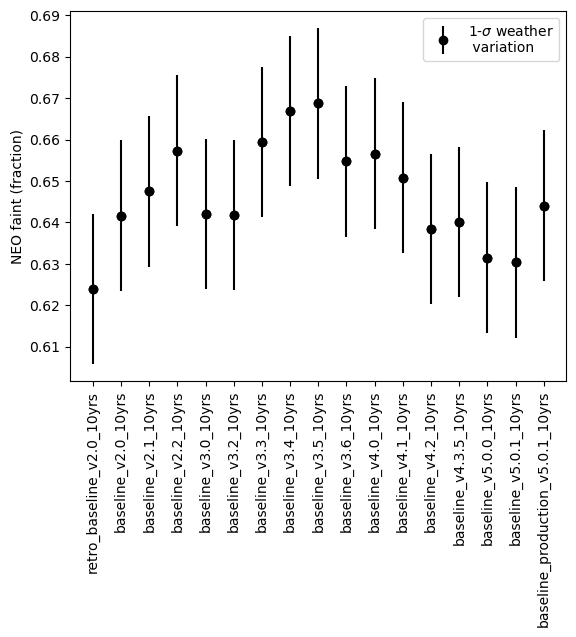

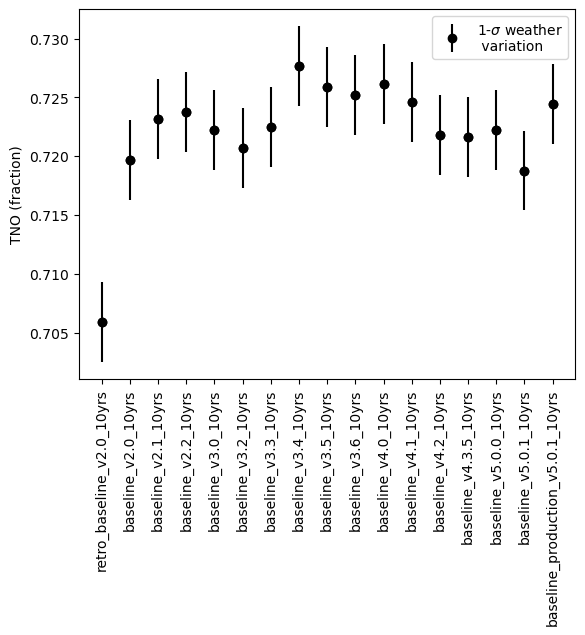

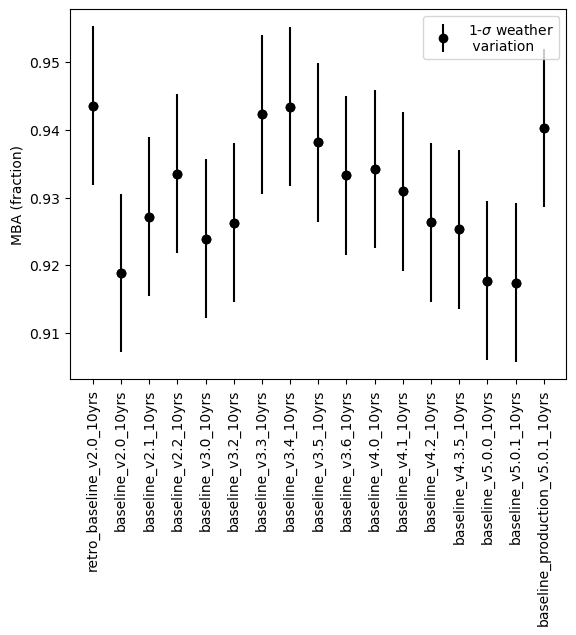

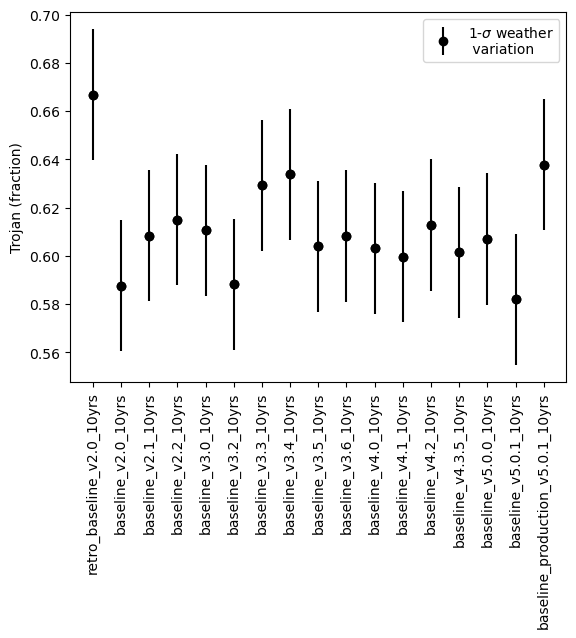

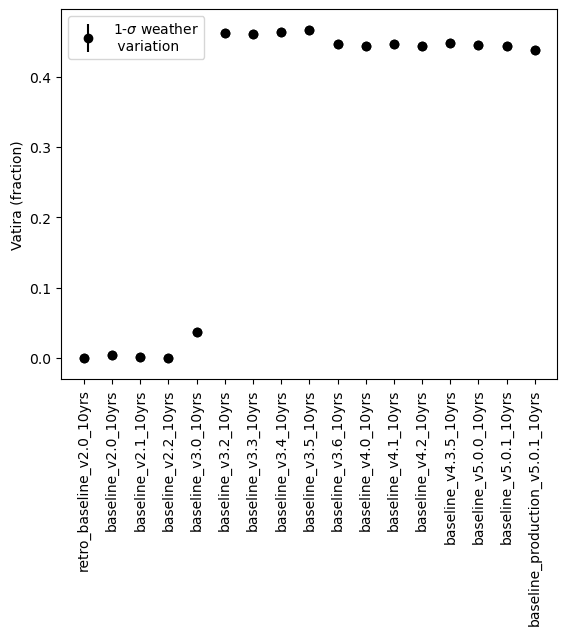

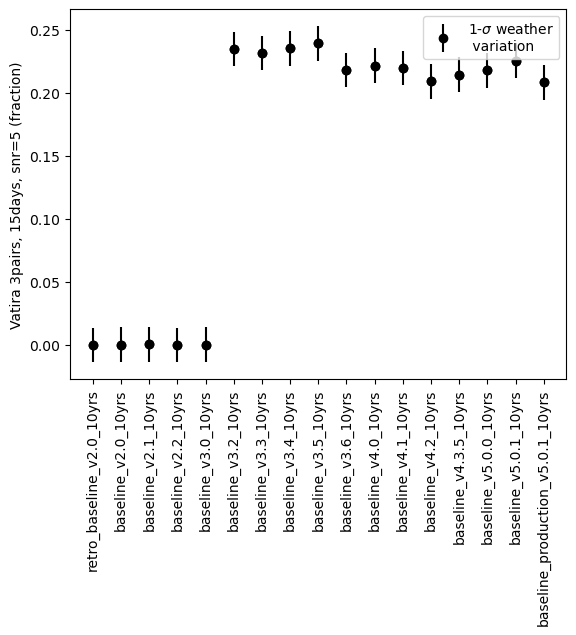

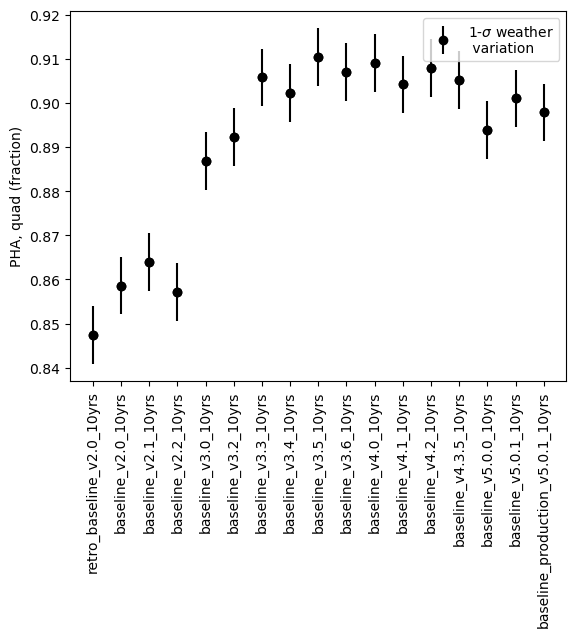

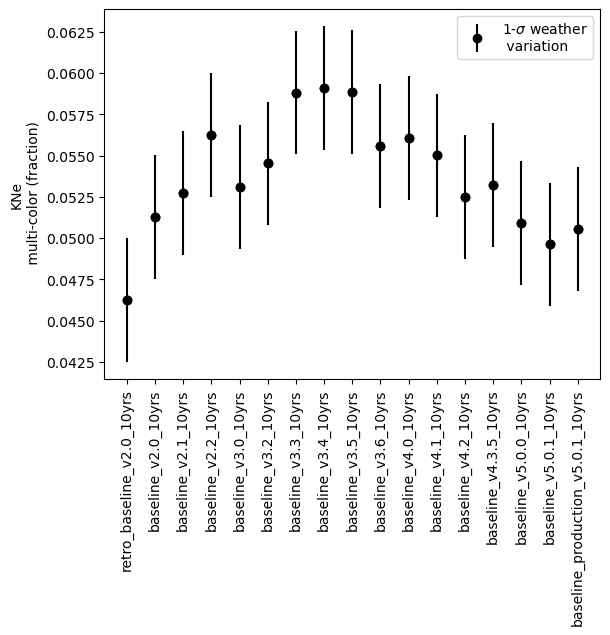

In [22]:
# Rough error bars from weather simulations
std_dict = {}
weather_runs = [run for run in data.index if 'weather' in run]
for col in data.columns:
    std_dict[col] = np.std(data.loc[weather_runs][col])

std_mag_dict = {}
for col in mag_data.columns:
    std_mag_dict[col] = np.std(mag_data.loc[weather_runs][col])
    
std_ddf_dict = {}
for col in ddf_data.columns:
    std_ddf_dict[col] = np.std(ddf_data.loc[weather_runs][col])
 

std_gaps_dict = {}
for col in gaps_data.columns:
    std_gaps_dict[col] = np.std(gaps_data.loc[weather_runs][col])


#col = data.columns[0]
for col in sub_data.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    if units[col] != '':
        label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])